In [22]:
import os
import time

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from skimage.metrics import structural_similarity as ssim

from tensorflow.keras.callbacks import Callback  # or from keras.callbacks import Callback


In [23]:
BASE_PATH = "../denoising-dirty-documents"

NOISY_DIR = os.path.join(BASE_PATH, "train", "train")
CLEAN_DIR = os.path.join(BASE_PATH, "train_cleaned", "train_cleaned")

IMG_HEIGHT = 420
IMG_WIDTH  = 540
CHANNELS   = 1  # grayscale

print("Noisy dir :", NOISY_DIR)
print("Clean dir :", CLEAN_DIR)


Noisy dir : ../denoising-dirty-documents\train\train
Clean dir : ../denoising-dirty-documents\train_cleaned\train_cleaned


### Loading noisy as input and clean as target
- Here is where we pair each noisy document with its corresponding clean document.

In [36]:
noisy_images = []
clean_images = []
file_names   = []

noisy_files = sorted(os.listdir(NOISY_DIR))
clean_files = sorted(os.listdir(CLEAN_DIR))

# make sure we only use files that exist in BOTH folders
common_files = sorted(list(set(noisy_files) & set(clean_files)))
print("Number of common image files:", len(common_files))

for fname in tqdm(common_files):
    noisy_path = os.path.join(NOISY_DIR, fname)
    clean_path = os.path.join(CLEAN_DIR, fname)

    noisy = load_img(
        noisy_path,
        color_mode="grayscale",
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    clean = load_img(
        clean_path,
        color_mode="grayscale",
        target_size=(IMG_HEIGHT, IMG_WIDTH)
    )

    noisy = img_to_array(noisy).astype("float32") / 255.0
    clean = img_to_array(clean).astype("float32") / 255.0

    noisy_images.append(noisy)
    clean_images.append(clean)
    file_names.append(fname)

noisy_images = np.array(noisy_images)
clean_images = np.array(clean_images)
file_names   = np.array(file_names)

print("Noisy shape:", noisy_images.shape)
print("Clean  shape:", clean_images.shape)


Number of common image files: 144


100%|██████████| 144/144 [00:00<00:00, 168.33it/s]


Noisy shape: (144, 420, 540, 1)
Clean  shape: (144, 420, 540, 1)


### Creating an independent test set

In [37]:
X_train, X_test, y_train, y_test, names_train, names_test = train_test_split(
    noisy_images,
    clean_images,
    file_names,
    test_size=0.2,
    random_state=42,
    shuffle=True
)


print("Train:", X_train.shape, y_train.shape)
print("Test :", X_test.shape, y_test.shape)


Train: (115, 420, 540, 1) (115, 420, 540, 1)
Test : (29, 420, 540, 1) (29, 420, 540, 1)


### Implementing an autoencoder for denoising
- This is the autoencoder:

    - Encoder: Conv + MaxPooling layers reduce the spatial size → compressed representation of the document.

    - Decoder: Conv + UpSampling layers reconstruct the image back to original size.

In [38]:
input_img = Input(shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS))

# ----- Encoder -----
x = Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = MaxPooling2D((2, 2), padding="same")(x)

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
encoded = MaxPooling2D((2, 2), padding="same")(x)

# ----- Decoder -----
x = Conv2D(64, (3, 3), activation="relu", padding="same")(encoded)
x = UpSampling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 420, 540, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 420, 540, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 210, 270, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 210, 270, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 105, 135, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 105, 135, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 210, 270, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 210, 270, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 420, 540, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 420, 540, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
class TimingCallback(Callback):
    def __init__(self, x_test, y_test, batch_size=4):
        super().__init__()
        self.x_test = x_test
        self.y_test = y_test
        self.batch_size = batch_size

        self.times = []       # cumulative training time (s)
        self.train_loss = []  # train MSE per epoch
        self.test_loss = []   # test MSE per epoch

        self._start_time = None

    def on_train_begin(self, logs=None):
        self._start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        elapsed = time.time() - self._start_time
        self.times.append(elapsed)

        train_mse = float(logs.get("loss"))
        self.train_loss.append(train_mse)

        test_mse = float(self.model.evaluate(
            self.x_test, self.y_test,
            batch_size=self.batch_size,
            verbose=0
        ))
        self.test_loss.append(test_mse)

        print(
            f"Epoch {epoch+1:03d} | "
            f"time={elapsed:.1f}s | "
            f"train MSE={train_mse:.5f} | "
            f"test MSE={test_mse:.5f}"
        )


In [ ]:
checkpoint = ModelCheckpoint(
    "best_autoencoder.h5",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

timing_cb = TimingCallback(X_test, y_test, batch_size=4)

history = autoencoder.fit(
    X_train, # this is the noisy images
    y_train, # this is the clean images (targets)
    epochs=80,
    batch_size=4,
    shuffle=True,
    validation_split=0.15,   # validation from training portion
    callbacks=[checkpoint, early_stop, timing_cb]
)

# final MSE on independent test set
test_mse_final = autoencoder.evaluate(X_test, y_test, verbose=0)
print("Final test MSE:", test_mse_final)


Epoch 1/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - loss: 0.1169
Epoch 1: val_loss improved from None to 0.08110, saving model to best_autoencoder.h5


Epoch 001 | time=13.5s | train MSE=0.09272 | test MSE=0.08802
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 522ms/step - loss: 0.0927 - val_loss: 0.0811
Epoch 2/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - loss: 0.0824
Epoch 2: val_loss did not improve from 0.08110
Epoch 002 | time=24.3s | train MSE=0.08208 | test MSE=0.08802
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 427ms/step - loss: 0.0821 - val_loss: 0.0811
Epoch 3/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step - loss: 0.0809
Epoch 3: val_loss improved from 0.08110 to 0.08109, saving model to best_autoencoder.h5


Epoch 003 | time=33.9s | train MSE=0.08208 | test MSE=0.08801
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 380ms/step - loss: 0.0821 - val_loss: 0.0811
Epoch 4/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.0826
Epoch 4: val_loss improved from 0.08109 to 0.08108, saving model to best_autoencoder.h5


Epoch 004 | time=46.5s | train MSE=0.08199 | test MSE=0.08801
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 576ms/step - loss: 0.0820 - val_loss: 0.0811
Epoch 5/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 954ms/step - loss: 0.0829
Epoch 5: val_loss did not improve from 0.08108
Epoch 005 | time=74.1s | train MSE=0.08208 | test MSE=0.08803
25/25 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 0.0821 - val_loss: 0.0811
Epoch 6/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 883ms/step - loss: 0.0824
Epoch 6: val_loss did not improve from 0.08108
Epoch 006 | time=99.9s | train MSE=0.08209 | test MSE=0.08803
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.0821 - val_loss: 0.0811
Epoch 7/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 891ms/step - loss: 0.0788
Epoch 7: val_loss did not improve from 0.08108
Epoch 007 | time=125.5s | train MSE=0.08209 | test MSE=0.08803
25/25 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - loss: 0.0821 - val_loss: 0.0811
Epoch 8/80
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - loss: 0.0823
Epoch 8: val_loss did not improve from 0.08108


### Denoise the test images

In [ ]:
y_pred = autoencoder.predict(X_test)
print("Prediction shape:", y_pred.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 799ms/step
Prediction shape: (29, 420, 540, 1)


- X_test represent noisy test images

- y_pred: model’s denoised outputs

In [40]:
mse_list  = []
ssim_list = []

for i in range(len(X_test)):
    true_img = y_test[i].squeeze()   # (H, W)
    pred_img = y_pred[i].squeeze()

    mse_val  = np.mean((true_img - pred_img) ** 2)
    ssim_val = ssim(true_img, pred_img, data_range=1.0)

    mse_list.append(mse_val)
    ssim_list.append(ssim_val)

# Table with metrics per image
results_df = pd.DataFrame({
    "image_name": names_test,
    "MSE": mse_list,
    "SSIM": ssim_list
})

print(results_df.head())

# Save full table for your report
results_df.to_csv("denoising_autoencoder_test_metrics.csv", index=False)

print("Mean MSE :", results_df["MSE"].mean())
print("Std  MSE :", results_df["MSE"].std())
print("Mean SSIM:", results_df["SSIM"].mean())
print("Std  SSIM:", results_df["SSIM"].std())


  image_name       MSE      SSIM
0     63.png  0.211820  0.405529
1    126.png  0.220978  0.432128
2    210.png  0.216876  0.374201
3     36.png  0.210382  0.383813
4    177.png  0.213237  0.326297
Mean MSE : 0.21469562
Std  MSE : 0.004014681559056044
Mean SSIM: 0.37520802101538137
Std  SSIM: 0.039842610438534626


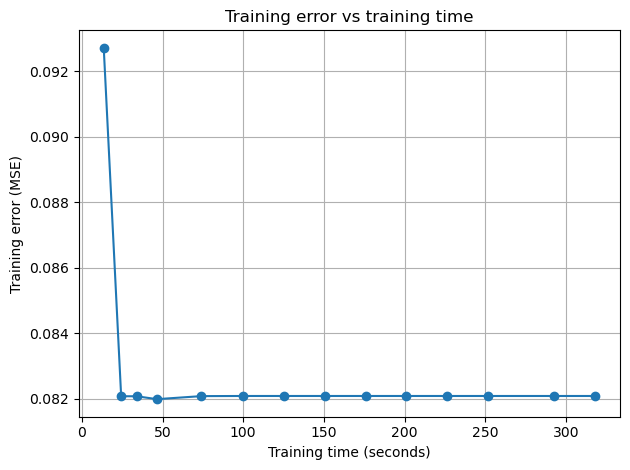

In [30]:
plt.figure()
plt.plot(timing_cb.times, timing_cb.train_loss, marker="o")
plt.xlabel("Training time (seconds)")
plt.ylabel("Training error (MSE)")
plt.title("Training error vs training time")
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("graph_training_error_vs_time.png", dpi=300)


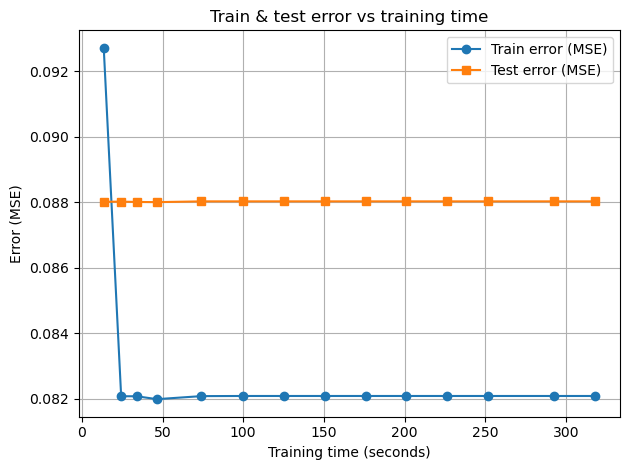

In [31]:
plt.figure()
plt.plot(timing_cb.times, timing_cb.train_loss,
         marker="o", label="Train error (MSE)")
plt.plot(timing_cb.times, timing_cb.test_loss,
         marker="s", label="Test error (MSE)")
plt.xlabel("Training time (seconds)")
plt.ylabel("Error (MSE)")
plt.title("Train & test error vs training time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("graph_train_test_error_vs_time.png", dpi=300)


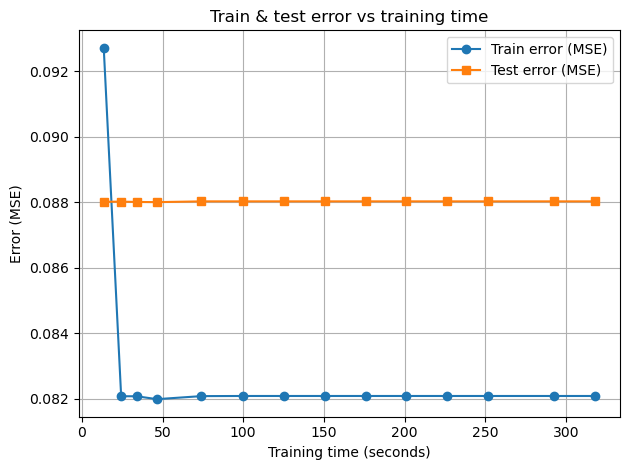

In [32]:
plt.figure()
plt.plot(timing_cb.times, timing_cb.train_loss,
         marker="o", label="Train error (MSE)")
plt.plot(timing_cb.times, timing_cb.test_loss,
         marker="s", label="Test error (MSE)")
plt.xlabel("Training time (seconds)")
plt.ylabel("Error (MSE)")
plt.title("Train & test error vs training time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("graph_train_test_error_vs_time.png", dpi=300)


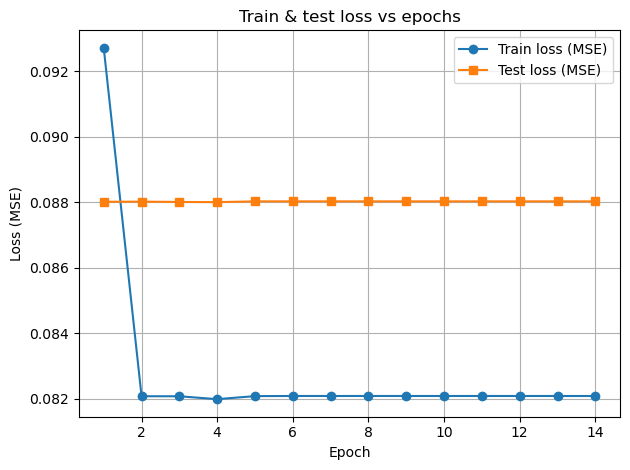

In [33]:
epochs_ran = np.arange(1, len(timing_cb.train_loss) + 1)

plt.figure()
plt.plot(epochs_ran, timing_cb.train_loss,
         marker="o", label="Train loss (MSE)")
plt.plot(epochs_ran, timing_cb.test_loss,
         marker="s", label="Test loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Train & test loss vs epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
# plt.savefig("graph_loss_vs_epochs.png", dpi=300)


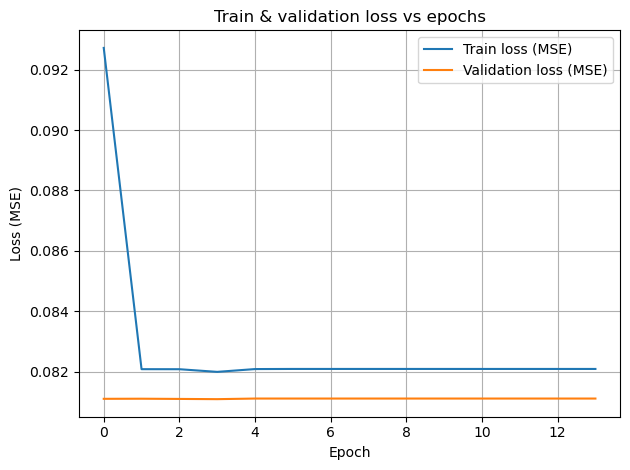

In [34]:
plt.figure()
plt.plot(history.history["loss"], label="Train loss (MSE)")
plt.plot(history.history["val_loss"], label="Validation loss (MSE)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Train & validation loss vs epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
